In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt
import cv2
from scipy.spatial import distance
from sqlalchemy import create_engine
from api_keys import post_key

from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

#### Get data from the csv file

In [2]:
#Create engine connection to PostgreSQL:¶
# rds_connection_string = f"{post_key}:{post_key}@localhost:5432/face_mask"
# engine = create_engine(f'postgresql://{rds_connection_string}')

In [3]:
# #query data
# face_mask_data_df = pd.read_sql_query('select * from face_mask_table', con=engine)
# face_mask_data_df.shape

(7553, 2)

In [16]:
face_mask_data_df = pd.read_csv("Resources/mask_no_mask.csv")
face_mask_data_df

,Unnamed: 0,image,target
0,3417,./Resources/Train/WithMask/Augmented_605_55749...,mask
1,4092,./Resources/Train/WithMask/Augmented_731_12561...,mask
2,8594,./Resources/faces/1 (4122).jpg,without_mask
3,7568,./Resources/faces/1 (3217).jpg,without_mask
4,4677,./Resources/Train/WithMask/Augmented_843_71192...,mask
...,...,...,...
12214,7018,./Resources/faces/1 (2733).jpg,without_mask
12215,7826,./Resources/faces/1 (3446).jpg,without_mask
12216,698,./Resources/Train/WithMask/899.png,mask
12217,8040,./Resources/faces/1 (3635).jpg,without_mask


#### Find total with mask and total without mask

In [17]:
mask_count = face_mask_data_df.groupby("target").count()
mask_count

,Unnamed: 0,image
target,,
mask,5000,5000
without_mask,7219,7219


In [18]:
x=mask_count.index
y = mask_count['image']

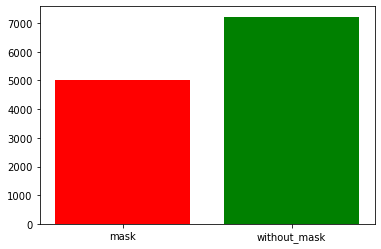

In [19]:
plt.bar(x,y,color=["red","green"])
plt.show()

In [20]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img

print("loading images...")
imagePaths = face_mask_data_df["image"]

data = []
labels = face_mask_data_df["target"]

# loop over the image paths
for path in imagePaths:

    # load the input image (224x224) and preprocess it
    image = load_img(path, target_size=(224, 224,224))
    image = img_to_array(image) # conversion to array format
    image = preprocess_input(image) #scaling the pixel in the input image to the range [-1, 1]
    # append to list
    data.append(image)

# Ensuring our training data is in NumPy array format
data = np.array(data, dtype="float32")
labels = np.array(labels)

loading images...


C:\Users\ubc\anaconda3\envs\maclearnpy\lib\site-packages\PIL\Image.py:952: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [ ]:
#### Preprocess
# perform one-hot encoding on the labels
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

# partition the data into training and testing splits using 80% of the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.20, stratify=labels, random_state=42)




#### Prepare for data augmentation: 
    - ImageDataGenerator accepts the original data, randomly transforms it, and returns only the new, transformed data.

In [9]:
train_data_aug = ImageDataGenerator(rotation_range=20,
                                    zoom_range=0.15,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.15,
                                    horizontal_flip=True,
                                    fill_mode="nearest")



### MobileNets: 
    Efficient Convolutional Neural Networks for Mobile Vision Applications
Note: each Keras Application expects a specific kind of input preprocessing. For MobileNet, call tf.keras.applications.mobilenet.preprocess_input on your inputs before passing them to the model. mobilenet.preprocess_input will scale input pixels between -1 and 1.
https://keras.io/api/applications/mobilenet/
 https://towardsdatascience.com/review-mobilenetv2-light-weight-model-image-classification-8febb490e61c


In [10]:
# load the MobileNetV2 network, ensuring the head FC layer sets are left off
baseModel = MobileNetV2(weights="imagenet", input_shape =(224, 224, 3), include_top=False, input_tensor=Input(shape=(224, 224, 3)))

### Fine Tuning :
    1. Build a new fully connected head and place it on top of the original architecture 
    2. “freezing” all layers in the body of the network to preserve what CONV layers have already learned.
    3. After the FC head has started to learn patterns in our dataset, we can pause training, unfreeze the body, and continue training, but with a very small learning rate until sufficient accuracy is obtained.
    https://www.pyimagesearch.com/2019/06/03/fine-tuning-with-keras-and-deep-learning/
    

In [11]:
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(100, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model
model = Model(inputs=baseModel.input, outputs=headModel)

# freeze the base layers by looping over so they will not be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

compile and train our face mask detector network:

In [12]:
print("[INFO] compiling model...")
model.compile(loss="binary_crossentropy", optimizer=Adam(lr=1e-4, decay=1e-4 / 14), metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit( train_data_aug.flow(trainX, trainY, batch_size=32),
               steps_per_epoch=20,    #32 is batch size
               validation_data=(testX, testY),
               validation_steps=len(testX) // 32,
               epochs=14)

[INFO] compiling model...
[INFO] training head...
  ...
    to  
  ['...']
Train for 20 steps, validate on 1511 samples
Epoch 1/14
20/20 [==============================] - 122s 6s/step - loss: 0.7990 - accuracy: 0.5562 - val_loss: 0.7482 - val_accuracy: 0.4880
Epoch 2/14
20/20 [==============================] - 145s 7s/step - loss: 0.6657 - accuracy: 0.6167 - val_loss: 0.5950 - val_accuracy: 0.6802
Epoch 3/14
20/20 [==============================] - 152s 8s/step - loss: 0.5292 - accuracy: 0.7422 - val_loss: 0.5105 - val_accuracy: 0.7713
Epoch 4/14
20/20 [==============================] - 141s 7s/step - loss: 0.4975 - accuracy: 0.7672 - val_loss: 0.4364 - val_accuracy: 0.8291
Epoch 5/14
20/20 [==============================] - 140s 7s/step - loss: 0.4605 - accuracy: 0.7703 - val_loss: 0.3855 - val_accuracy: 0.8737
Epoch 6/14
20/20 [==============================] - 129s 6s/step - loss: 0.4108 - accuracy: 0.8344 - val_loss: 0.3331 - val_accuracy: 0.8936
Epoch 7/14
20/20 [================

#### Evaluate the resulting model on the test set:

In [24]:
# Make predictions on the testing set
print("predicting...")
predIndx = model.predict(testX, batch_size=32)

# for each image in the testing set we need to find the index of the label with corresponding largest predicted probability
predIndx = np.argmax(predIndx, axis=1)

#show the prediction in a dataframe
pd.DataFrame({"Actual":testY.argmax(axis=1)[:10],
              "Predicted":predIndx[:10]})


predicting...


,Actual,Predicted
0,1,1
1,1,1
2,1,1
3,1,1
4,0,0
5,1,1
6,0,0
7,1,1
8,1,1
9,1,1


In [14]:
#get target names
lb.classes_

array(['with_mask', 'without_mask'], dtype='<U12')

In [15]:
# show a classification report
from sklearn.metrics import classification_report
print(classification_report(testY.argmax(axis=1), predIndx, target_names=lb.classes_))


              precision    recall  f1-score   support

   with_mask       0.98      0.85      0.91       745
without_mask       0.87      0.99      0.93       766

    accuracy                           0.92      1511
   macro avg       0.93      0.92      0.92      1511
weighted avg       0.93      0.92      0.92      1511



In [16]:
# save the model to disk
print("saving mask detector model...")
model.save("./Saved_Model/MobileNetV2_model", save_format="h5")
#model.save("./model-010.h5")

saving mask detector model...


In [ ]:
!pip install pickle 
import pickle
pickle.dump(logreg, open('./Saved_Model/MobileNetV2_model.pkl', 'wb'))

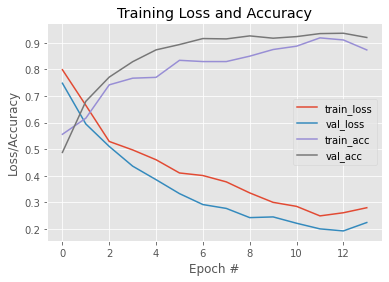

In [17]:
# plot the training loss and accuracy
N = 14  #epocs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")
plt.savefig("./Images/MobileNetV2_accracy_plot")

In [4]:
# test for realtime prediction

face_model = cv2.CascadeClassifier('./Resources/haarcascade_frontalface_default.xml')

img = cv2.imread('./Resources/Test/WithMask/754.png')

img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)

faces = face_model.detectMultiScale(img,scaleFactor=1.1, minNeighbors=4)





In [5]:
mask_label = {0:'Mask Found',1:'No Mask Found'}
color_label = {0:(0,255,0),1:(255,0,0)}
MIN_DISTANCE = 0

#check for no. of faces in the image
# if more than one face found,
if len(faces)>=1:
    label = [0 for i in range(len(faces))]
    for i in range(len(faces)-1):
        for j in range(i+1, len(faces)):
            dist = distance.euclidean(faces[i][:2],faces[j][:2])
            if dist<MIN_DISTANCE:
                label[i] = 1
                label[j] = 1
    new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image
    
    # For every face found,   
    for i in range(len(faces)):
        (x,y,w,h) = faces[i]
        crop = new_img[y:y+h,x:x+w]
        crop = cv2.resize(crop,(224,224))
        crop = np.reshape(crop,[1,224,224,3])/255.0        
        mask_result = model.predict(crop)
        
        cv2.putText(new_img,mask_label[round(mask_result[0][0])],(x, y+90), cv2.FONT_HERSHEY_SIMPLEX,0.5,color_label[label[i]],2)
        cv2.rectangle(new_img,(x,y),(x+w,y+h),color_label[label[i]],1)
        
    plt.figure(figsize=(10,10))
    plt.imshow(new_img)
            
else:
    print("No image")

NameError: name 'model' is not defined